In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import confusion_matrix, classification_report, mean_absolute_error, mean_absolute_percentage_error, f1_score
from scipy.stats import randint
import time
import os

In [2]:
#Open File
file = "02_Used_Cars_Pipeline.csv"
df = pd.read_csv(file)

In [4]:
#Transforming Features back to non log
df["car_price"] = np.expm1(df["log_price"])
df["car_age"] = np.expm1(df["log_car_age"])
df["odometer"] = np.expm1(df["log_odometer"])
df["miles_age"] = np.expm1(df["log_miles_age"])

Distribution Car Prices by Segment

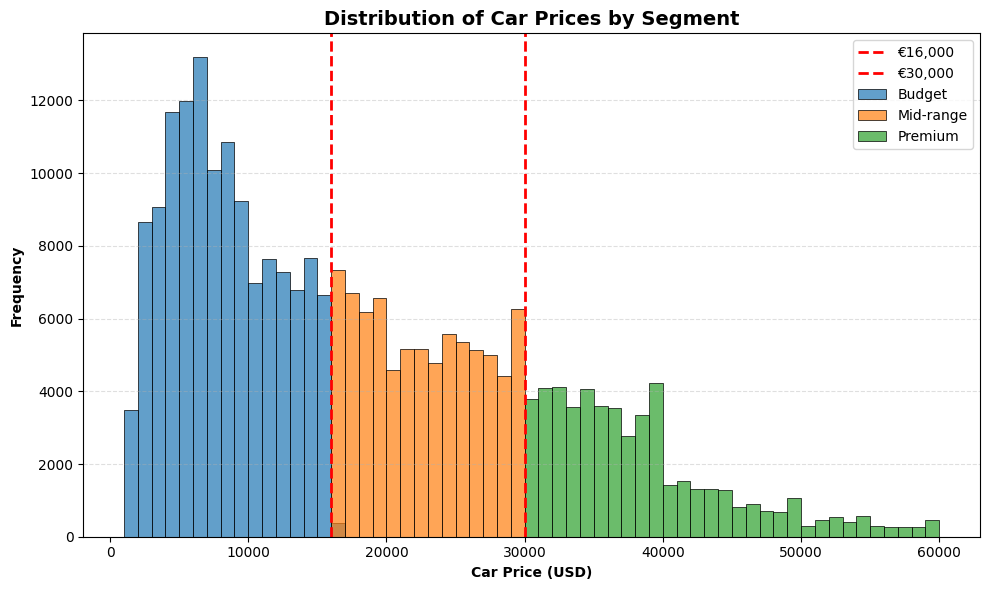

In [13]:
#Labels + Colors
label_map = {1: 'Budget', 2: 'Mid-range', 3: 'Premium'}
palette = {'Budget': '#1f77b4', 'Mid-range': '#ff7f0e', 'Premium': '#2ca02c'}
df['price_label'] = df['price_segment'].map(label_map)

# 1000 USD Bins
bins = np.arange(1000, 60001, 1000)

# Plot Figure
plt.figure(figsize=(10, 6))
for label in ['Budget', 'Mid-range', 'Premium']:
    subset = df[df['price_label'] == label]
    sns.histplot(
        subset["car_price"],
        bins=bins,
        color=palette[label],
        label=label,
        alpha=0.7,
        linewidth=0.5
    )

# Add Vertical Segment Seperation Lines
plt.axvline(16000, color='red', linestyle='--', linewidth=2, label='€16,000')
plt.axvline(30000, color='red', linestyle='--', linewidth=2, label='€30,000')

# Titles, Axes and Saving
plt.title('Distribution of Car Prices by Segment', fontsize=14, fontweight='bold')
plt.xlabel('Car Price (USD)',fontweight='bold')
plt.ylabel('Frequency',fontweight='bold')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
output_path = "03_EDA_visuals_pdf/Car Price Distribution.pdf"
plt.savefig(output_path, bbox_inches='tight')
plt.show()

Box Plots Car Age and Odometer for each Segment

/var/folders/dv/vms2hsvs4r56fp14cfs24t2h0000gn/T/ipykernel_92787/3033813102.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax1 = sns.boxplot(ax=axes[0], x='segment_label', y='car_age', data=df, palette=palette,order=order)
/var/folders/dv/vms2hsvs4r56fp14cfs24t2h0000gn/T/ipykernel_92787/3033813102.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax2 = sns.boxplot(ax=axes[1], x='segment_label', y='odometer', data=df, palette=palette,order=order)


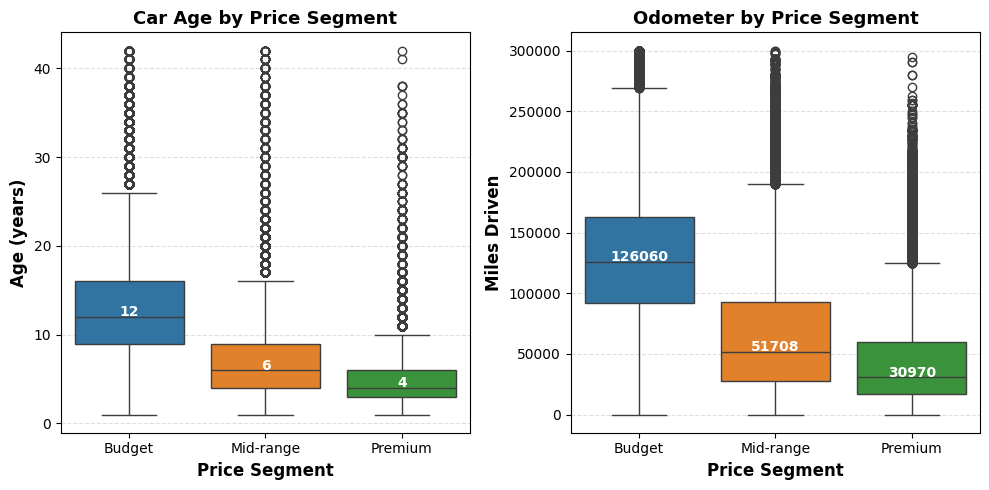

In [11]:
# Segmentlabels
label_map = {1: 'Budget', 2: 'Mid-range', 3: 'Premium'}
df['segment_label'] = df['price_segment'].map(label_map)

#Median Values 
medians_age = df.groupby('segment_label')['car_age'].median()
medians_odo = df.groupby('segment_label')['odometer'].median()
order = ['Budget', 'Mid-range', 'Premium']

#Plot Double Visualization 
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot Car age
ax1 = sns.boxplot(ax=axes[0], x='segment_label', y='car_age', data=df, palette=palette,order=order)
axes[0].set_title('Car Age by Price Segment', fontsize=13, fontweight='bold')
axes[0].set_xlabel('Price Segment', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Age (years)', fontsize=12, fontweight='bold')
axes[0].grid(axis='y', linestyle='--', alpha=0.4)

#Fill in Median Values
for tick, segment in enumerate(order):
    median_val = medians_age[segment]
    axes[0].text(tick, median_val + 0.5, f"{median_val:.0f}", 
                 ha='center', va='center', fontweight='bold', color='white')


# Plot Odometer
ax2 = sns.boxplot(ax=axes[1], x='segment_label', y='odometer', data=df, palette=palette,order=order)
axes[1].set_title('Odometer by Price Segment', fontsize=13, fontweight='bold')
axes[1].set_xlabel('Price Segment', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Miles Driven', fontsize=12, fontweight='bold')
axes[1].grid(axis='y', linestyle='--', alpha=0.4)

#Fill in Median Values
for tick, segment in enumerate(order):
    median_val = medians_odo[segment]
    axes[1].text(tick, median_val + 3600, f"{median_val:.0f}", 
                 ha='center', va='center', fontweight='bold', color='white')

#Save Figure
plt.tight_layout()

output_path = "03_EDA_visuals_pdf/Segment_Boxplots.pdf"
plt.savefig(output_path, bbox_inches='tight')
plt.show()


Distribution per Segment

In [6]:
#Capitalize First letter for Legenda
df['fuel'] = df['fuel'].str.capitalize()
df['type_grouped'] = df['type_grouped'].str.capitalize()
df['transmission'] = df['transmission'].str.capitalize()

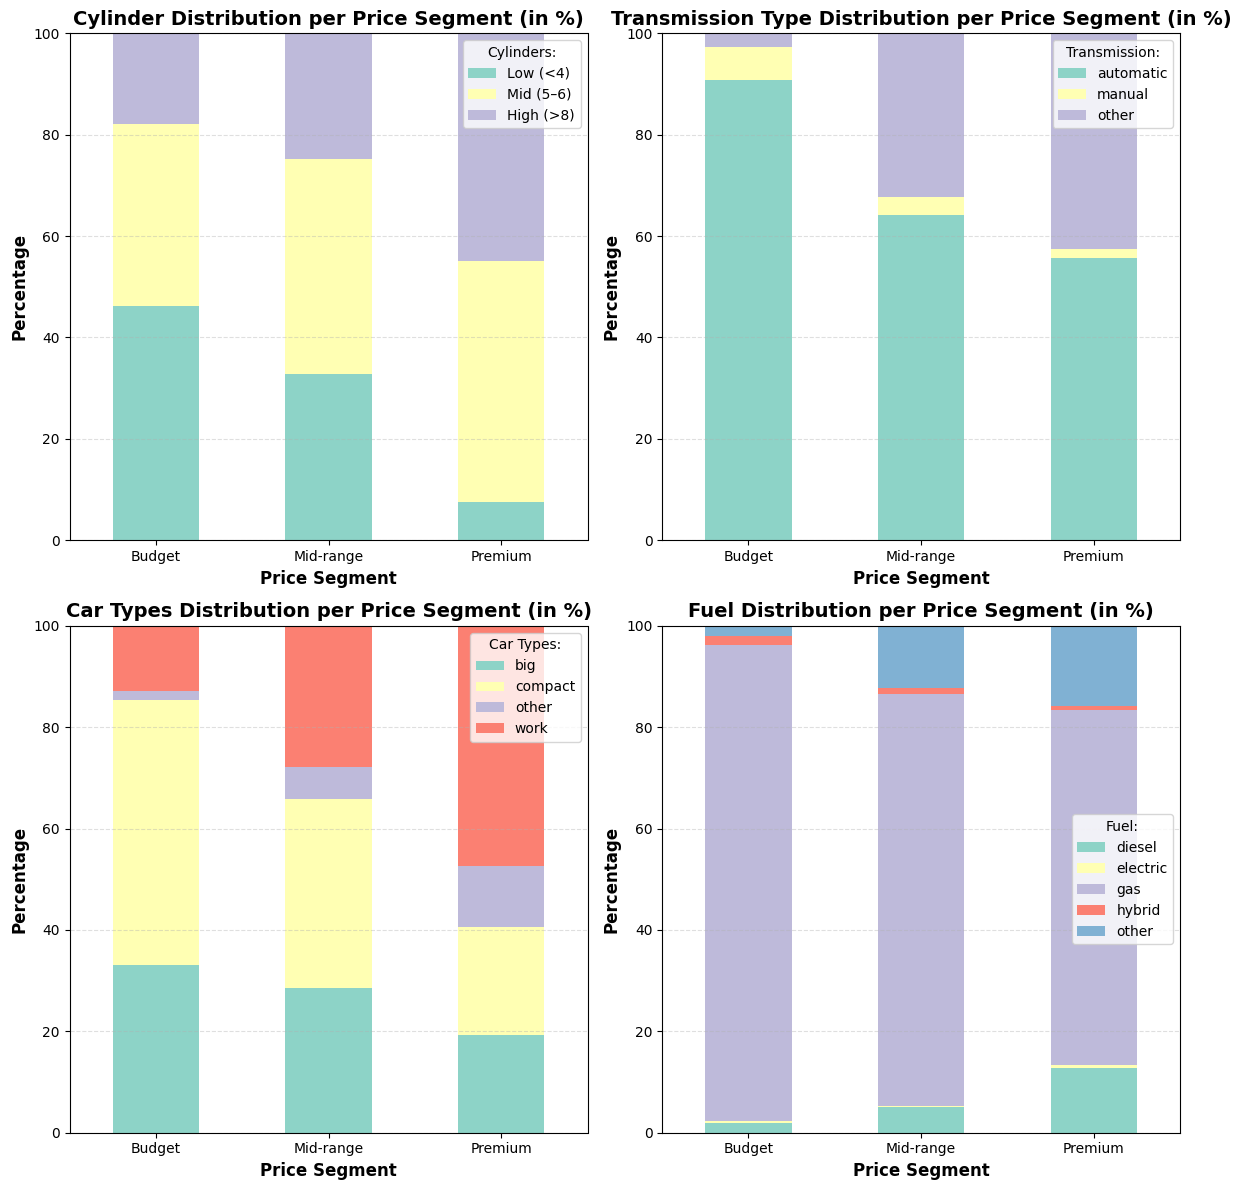

In [12]:
#Label Map
label_map = {1: 'Budget', 2: 'Mid-range', 3: 'Premium'}
df['segment_label'] = df['price_segment'].map(label_map)

# Subplot grid 2x2
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

# Subplot [0, 0]: Cylinder Distribution
counts = df.groupby(['segment_label', 'cylinders_cat']).size().reset_index(name='count')
counts['percent'] = counts.groupby('segment_label')['count'].transform(lambda x: 100 * x / x.sum())
pivot_df = counts.pivot(index='segment_label', columns='cylinders_cat', values='percent').fillna(0)

pivot_df.plot(kind='bar', stacked=True, color=sns.color_palette("Set3", n_colors=pivot_df.shape[1]), ax=axes[0, 0])
axes[0, 0].set_title('Cylinder Distribution per Price Segment (in %)', fontsize=14, fontweight='bold')
axes[0, 0].set_ylabel('Percentage', fontsize=12, fontweight='bold')
axes[0, 0].set_ylim(0, 100)
axes[0, 0].set_xlabel('Price Segment', fontsize=12, fontweight='bold')
axes[0, 0].grid(axis='y', linestyle='--', alpha=0.4)
axes[0, 0].tick_params(axis='x', rotation=0)
handles, labels = axes[0,0].get_legend_handles_labels()
label_map = {
    '1': 'Low (<4)',
    '2': 'Mid (5-6)',
    '3': 'High (>8)'
}
mapped_labels = [label_map.get(label, label) for label in labels]

axes[0,0].legend(handles=handles, labels=mapped_labels, title='Cylinders:')

# Subplot [0, 1]: Cylinder Distribution
counts = df.groupby(['segment_label', 'transmission']).size().reset_index(name='count')
counts['percent'] = counts.groupby('segment_label')['count'].transform(lambda x: 100 * x / x.sum())
pivot_df = counts.pivot(index='segment_label', columns='transmission', values='percent').fillna(0)

pivot_df.plot(kind='bar', stacked=True, color=sns.color_palette("Set3", n_colors=pivot_df.shape[1]), ax=axes[0, 1])
axes[0, 1].set_title('Transmission Type Distribution per Price Segment (in %)', fontsize=14, fontweight='bold')
axes[0, 1].set_ylim(0, 100)
axes[0, 1].set_xlabel('Price Segment', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Percentage', fontsize=12, fontweight='bold')
axes[0, 1].legend(title='Transmission:')
axes[0, 1].grid(axis='y', linestyle='--', alpha=0.4)
axes[0, 1].tick_params(axis='x', rotation=0)

#Subplot [1,0]
counts = df.groupby(['segment_label', 'type_grouped']).size().reset_index(name='count')
counts['percent'] = counts.groupby('segment_label')['count'].transform(lambda x: 100 * x / x.sum())
pivot_df = counts.pivot(index='segment_label', columns='type_grouped', values='percent').fillna(0)

pivot_df.plot(kind='bar', stacked=True, color=sns.color_palette("Set3", n_colors=pivot_df.shape[1]), ax=axes[1, 0])
axes[1, 0].set_title('Car Types Distribution per Price Segment (in %)', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Price Segment', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Percentage', fontsize=12, fontweight='bold')
axes[1, 0].set_ylim(0, 100)
axes[1, 0].legend(title='Car Types:')
axes[1, 0].grid(axis='y', linestyle='--', alpha=0.4)
axes[1, 0].tick_params(axis='x', rotation=0)


#Subplot [1,1]
counts = df.groupby(['segment_label', 'fuel']).size().reset_index(name='count')
counts['percent'] = counts.groupby('segment_label')['count'].transform(lambda x: 100 * x / x.sum())
pivot_df = counts.pivot(index='segment_label', columns='fuel', values='percent').fillna(0)

pivot_df.plot(kind='bar', stacked=True, color=sns.color_palette("Set3", n_colors=pivot_df.shape[1]), ax=axes[1, 1])
axes[1, 1].set_title('Fuel Distribution per Price Segment (in %)', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Price Segment', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Percentage', fontsize=12, fontweight='bold')
axes[1, 1].set_ylim(0, 100)
axes[1, 1].legend(title='Fuel:')
axes[1, 1].grid(axis='y', linestyle='--', alpha=0.4)
axes[1, 1].tick_params(axis='x', rotation=0)

plt.tight_layout()
output_path = "03_EDA_visuals_pdf/Heterogeneous_Appendix.pdf"
plt.savefig(output_path ,bbox_inches='tight')
plt.show()
